In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import SALib.analyze.morris
from SALib.sample import morris

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from tqdm import tqdm

from infrasim.optimise import *
from infrasim.utils import *

In [2]:
def process_morris_results(problem,param_values,collected_results,num_levels):
    '''Process output from Morris sensitivitys
    '''
    Si = SALib.analyze.morris.analyze(problem,
                                      np.array(param_values),
                                      np.array(collected_results),
                                      print_to_console=False,
                                      num_levels=num_levels)

    sensitivity_results = pd.DataFrame.from_dict(Si)
    return sensitivity_results


def calculate_relative_influence(sensitivity_results):
    '''Return relative influence (%) of each parameter from sensitivity
    '''
    sensitivity = sensitivity_results.copy()
    sensitivity['rel'] = abs(sensitivity['mu'])/abs(sensitivity['mu']).sum()*100
    sensitivity['mu'] = sensitivity['mu']
    sensitivity = sensitivity[['names','rel']]
    sensitivity = sensitivity.sort_values(by='names',ascending=True).reset_index(drop=True)
    sensitivity.names = sensitivity.names.str.replace('_',' ')
    sensitivity.names = sensitivity.names.str.title()
    sensitivity.names = sensitivity.names.str.replace('Res','RES')
    sensitivity.names = sensitivity.names.str.replace('Coop','COO')
    sensitivity.names = sensitivity.names.str.replace('To','to')
    sensitivity.names = sensitivity.names.str.replace('Westbank','West Bank')
    return sensitivity

In [3]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

timesteps   = None
num_levels  = 10
N           = 10

# Set up problem for sensitivity analysis # name:[lower_bound,upper_bound]
params = {'coop_res_target'                 : [0,0.5],
          'jordan_to_westbank'              : [0,10**12],
          'jordan_to_israel'                : [0,10**12],
          'israel_to_westbank'              : [0,10**12],
          'israel_to_jordan'                : [0,10**12],
          'israel_to_gaza'                  : [0,10**12],
          'westbank_to_israel'              : [0,10**12],
          'westbank_to_jordan'              : [0,10**12],
          'self_sufficiency_factor'         : [0,0.9],
         }

problem = {'num_vars'    : len(params.keys()),
           'names'       : [i for i in params.keys()],
           'bounds'      : [params[i] for i in params.keys()]
          }

# create parameter values
param_values = morris.sample(problem,N=N,
                             num_levels=num_levels,
                             local_optimization=True)

# Run analysis with the specified parameter values
collected_caps_israel   = []
collected_caps_jordan   = []
collected_caps_westbank = []
collected_caps_gaza     = []

for param_set in tqdm(param_values,total=len(param_values)):

    model_run = nextra(nodes,edges,flows,
                       timesteps=timesteps,
                       energy_objective=True,
                       scenario='COO',
                       super_sink=False,
                       super_source=False,
                       # params
                       coo_res_factor=param_set[0],
                       jordan_to_westbank=param_set[1],
                       jordan_to_israel=param_set[2],
                       israel_to_westbank=param_set[3],
                       israel_to_jordan=param_set[4],
                       israel_to_gaza=param_set[5],
                       westbank_to_israel=param_set[6],
                       westbank_to_jordan=param_set[7],
                       self_sufficiency_factor=param_set[8],
                      )
    
    # build, run, and get results
    model_run.build()
    model_run.run(pprint=False)
    model_results = model_run.get_results()
    
    # get capacities
    caps = model_results.results_capacities.groupby(by=['node','territory']).max().reset_index()
    caps = caps.groupby(by='territory').sum().reset_index()
    
    # append collected capacities
    collected_caps_israel.append(caps.loc[caps.territory == 'Israel','value'].values[0])
    collected_caps_jordan.append(caps.loc[caps.territory == 'Jordan','value'].values[0])
    collected_caps_westbank.append(caps.loc[caps.territory == 'West Bank','value'].values[0])
    collected_caps_gaza.append(caps.loc[caps.territory == 'Gaza','value'].values[0])

  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03



  1%|▊                                                                                    | 1/100 [02:38<4:20:53, 158.11s/it]

  2%|█▋                                                                                   | 2/100 [05:20<4:22:18, 160.60s/it]

  3%|██▌                                                                                  | 3/100 [08:00<4:19:07, 160.28s/it]

  4%|███▍                                                                                 | 4/100 [10:42<4:17:19, 160.83s/it]

  5%|████▎                                                                                | 5/100 [13:23<4:14:49, 160.94s/it]

  6%|█████                                                                                | 6/100 [16:06<4:13:33, 161.84s/it]

  7%|█████▉                                                                               | 7/100 [18:52<4:12:46, 163.08s/it]

  8%|██████▊                                                                              | 8/100 [21:39<4:12:06, 164.42s/it]

  9%|███████▋                                                                             | 9/100 [24:27<4:10:55, 165.44s/it]

 10%|████████▍                                                                           | 10/100 [27:14<4:09:08, 166.10s/it]

 11%|█████████▏                                                                          | 11/100 [29:41<3:57:41, 160.24s/it]

 12%|██████████                                                                          | 12/100 [32:11<3:50:11, 156.95s/it]

 13%|██████████▉                                                                         | 13/100 [34:39<3:43:51, 154.38s/it]

 14%|███████████▊                                                                        | 14/100 [37:17<3:42:47, 155.43s/it]

 15%|████████████▌                                                                       | 15/100 [39:55<3:41:26, 156.31s/it]

 16%|█████████████▍                                                                      | 16/100 [42:36<3:40:41, 157.63s/it]

 17%|██████████████▎                                                                     | 17/100 [45:24<3:42:18, 160.71s/it]

 18%|███████████████                                                                     | 18/100 [48:27<3:48:56, 167.52s/it]

 19%|███████████████▉                                                                    | 19/100 [51:05<3:42:05, 164.52s/it]

 20%|████████████████▊                                                                   | 20/100 [53:44<3:37:06, 162.83s/it]

 21%|█████████████████▋                                                                  | 21/100 [56:31<3:36:08, 164.16s/it]

 22%|██████████████████▍                                                                 | 22/100 [59:17<3:34:05, 164.69s/it]

 23%|██████████████████▊                                                               | 23/100 [1:02:05<3:32:37, 165.68s/it]

 24%|███████████████████▋                                                              | 24/100 [1:04:57<3:32:11, 167.52s/it]

 25%|████████████████████▌                                                             | 25/100 [1:07:48<3:30:52, 168.70s/it]

 26%|█████████████████████▎                                                            | 26/100 [1:25:24<8:56:19, 434.86s/it]

 27%|██████████████████████▏                                                           | 27/100 [1:32:07<8:37:20, 425.22s/it]

 28%|██████████████████████▉                                                           | 28/100 [1:39:24<8:34:36, 428.84s/it]

 29%|███████████████████████▍                                                         | 29/100 [1:51:30<10:12:49, 517.88s/it]

 30%|████████████████████████▌                                                         | 30/100 [1:53:48<7:51:27, 404.11s/it]

 31%|█████████████████████████▍                                                        | 31/100 [1:56:47<6:26:52, 336.41s/it]

 32%|██████████████████████████▏                                                       | 32/100 [1:59:43<5:26:55, 288.46s/it]

 33%|███████████████████████████                                                       | 33/100 [2:02:38<4:43:57, 254.29s/it]

 34%|███████████████████████████▉                                                      | 34/100 [2:05:32<4:13:10, 230.15s/it]

 35%|████████████████████████████▋                                                     | 35/100 [2:08:31<3:52:55, 215.00s/it]

 36%|█████████████████████████████▌                                                    | 36/100 [2:11:30<3:37:46, 204.16s/it]

 37%|██████████████████████████████▎                                                   | 37/100 [2:14:34<3:27:55, 198.02s/it]

 38%|███████████████████████████████▏                                                  | 38/100 [2:17:17<3:13:44, 187.49s/it]

 39%|███████████████████████████████▉                                                  | 39/100 [2:20:03<3:03:59, 180.98s/it]

 40%|████████████████████████████████▊                                                 | 40/100 [2:22:49<2:56:30, 176.51s/it]

 41%|█████████████████████████████████▌                                                | 41/100 [2:25:44<2:53:14, 176.17s/it]

 42%|██████████████████████████████████▍                                               | 42/100 [2:28:32<2:47:48, 173.60s/it]

 43%|███████████████████████████████████▎                                              | 43/100 [2:31:21<2:43:35, 172.20s/it]

 44%|████████████████████████████████████                                              | 44/100 [2:34:11<2:40:17, 171.75s/it]

 45%|████████████████████████████████████▉                                             | 45/100 [2:36:57<2:35:51, 170.03s/it]

 46%|█████████████████████████████████████▋                                            | 46/100 [2:39:27<2:27:30, 163.89s/it]

 47%|██████████████████████████████████████▌                                           | 47/100 [2:41:49<2:19:02, 157.40s/it]

 48%|███████████████████████████████████████▎                                          | 48/100 [2:44:13<2:12:54, 153.36s/it]

 49%|████████████████████████████████████████▏                                         | 49/100 [2:46:35<2:07:21, 149.84s/it]

 50%|█████████████████████████████████████████                                         | 50/100 [2:48:56<2:02:41, 147.23s/it]

 51%|█████████████████████████████████████████▊                                        | 51/100 [2:51:42<2:04:43, 152.73s/it]

 52%|██████████████████████████████████████████▋                                       | 52/100 [2:54:28<2:05:26, 156.81s/it]

 53%|███████████████████████████████████████████▍                                      | 53/100 [2:57:14<2:05:02, 159.62s/it]

 54%|████████████████████████████████████████████▎                                     | 54/100 [3:00:02<2:04:16, 162.11s/it]

 55%|█████████████████████████████████████████████                                     | 55/100 [3:02:53<2:03:30, 164.67s/it]

 56%|█████████████████████████████████████████████▉                                    | 56/100 [3:05:41<2:01:33, 165.76s/it]

 57%|██████████████████████████████████████████████▋                                   | 57/100 [3:08:35<2:00:41, 168.40s/it]

 58%|███████████████████████████████████████████████▌                                  | 58/100 [3:11:32<1:59:28, 170.68s/it]

 59%|████████████████████████████████████████████████▍                                 | 59/100 [3:14:25<1:57:18, 171.66s/it]

 60%|█████████████████████████████████████████████████▏                                | 60/100 [3:17:18<1:54:34, 171.86s/it]

 61%|██████████████████████████████████████████████████                                | 61/100 [3:20:06<1:50:57, 170.71s/it]

 62%|██████████████████████████████████████████████████▊                               | 62/100 [3:22:55<1:47:48, 170.23s/it]

 63%|███████████████████████████████████████████████████▋                              | 63/100 [3:25:38<1:43:39, 168.10s/it]

 64%|████████████████████████████████████████████████████▍                             | 64/100 [3:28:22<1:40:08, 166.91s/it]

 65%|█████████████████████████████████████████████████████▎                            | 65/100 [3:31:09<1:37:21, 166.89s/it]

 66%|██████████████████████████████████████████████████████                            | 66/100 [3:33:53<1:34:09, 166.15s/it]

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [3:36:39<1:31:16, 165.96s/it]

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [3:39:21<1:27:55, 164.87s/it]

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [3:42:06<1:25:09, 164.81s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [3:44:48<1:21:57, 163.90s/it]

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [3:47:34<1:19:34, 164.63s/it]

 72%|███████████████████████████████████████████████████████████                       | 72/100 [3:50:21<1:17:05, 165.19s/it]

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [3:53:06<1:14:20, 165.19s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [3:55:49<1:11:21, 164.67s/it]

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [3:58:32<1:08:24, 164.17s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [4:01:21<1:06:10, 165.45s/it]

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [4:04:04<1:03:13, 164.95s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [4:06:48<1:00:17, 164.41s/it]

 79%|██████████████████████████████████████████████████████████████████▎                 | 79/100 [4:09:35<57:54, 165.45s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [4:12:20<55:03, 165.18s/it]

 81%|████████████████████████████████████████████████████████████████████                | 81/100 [4:15:13<53:01, 167.46s/it]

 82%|████████████████████████████████████████████████████████████████████▉               | 82/100 [4:18:03<50:31, 168.39s/it]

 83%|█████████████████████████████████████████████████████████████████████▋              | 83/100 [4:20:57<48:07, 169.85s/it]

 84%|██████████████████████████████████████████████████████████████████████▌             | 84/100 [4:23:51<45:40, 171.30s/it]

 85%|███████████████████████████████████████████████████████████████████████▍            | 85/100 [4:27:03<44:22, 177.51s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [4:36:52<1:10:13, 300.98s/it]

 87%|█████████████████████████████████████████████████████████████████████████           | 87/100 [4:39:48<57:01, 263.23s/it]

 88%|█████████████████████████████████████████████████████████████████████████▉          | 88/100 [4:42:39<47:08, 235.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████▊         | 89/100 [4:45:30<39:41, 216.45s/it]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [4:48:12<33:20, 200.09s/it]

 91%|████████████████████████████████████████████████████████████████████████████▍       | 91/100 [4:50:58<28:26, 189.64s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▎      | 92/100 [4:53:40<24:11, 181.42s/it]

 93%|██████████████████████████████████████████████████████████████████████████████      | 93/100 [4:56:27<20:40, 177.26s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▉     | 94/100 [4:59:13<17:21, 173.66s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▊    | 95/100 [5:02:02<14:22, 172.44s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▋   | 96/100 [5:04:48<11:22, 170.56s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [5:07:36<08:28, 169.64s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [5:10:23<05:37, 168.80s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 99/100 [5:13:23<02:52, 172.16s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [5:16:25<00:00, 189.85s/it]


In [4]:
israel_results = process_morris_results(problem,param_values,collected_caps_israel,num_levels)
jordan_results = process_morris_results(problem,param_values,collected_caps_jordan,num_levels)
westbank_results = process_morris_results(problem,param_values,collected_caps_westbank,num_levels)
gaza_results = process_morris_results(problem,param_values,collected_caps_gaza,num_levels)

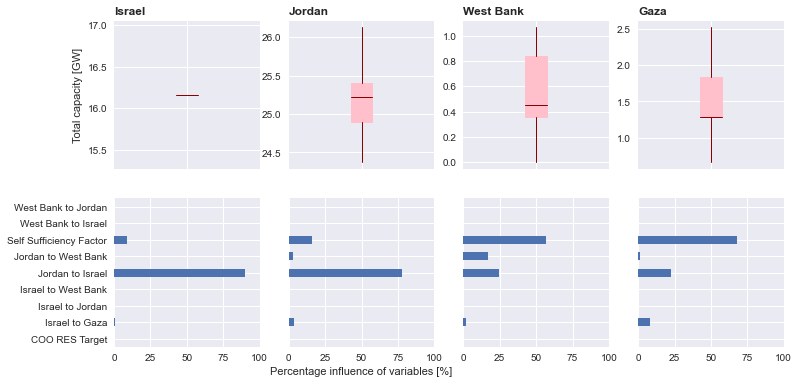

In [14]:
plt.style.use('seaborn')

f,ax=plt.subplots(nrows=2,ncols=4,figsize=(12,6))

# plot boxplot
israel_caps = pd.DataFrame({'Israel' : collected_caps_israel,})
jordan_caps = pd.DataFrame({'Jordan' : collected_caps_jordan,})
westbank_caps = pd.DataFrame({'West Bank' : collected_caps_westbank,})
gaza_caps = pd.DataFrame({'Gaza' : collected_caps_gaza,})

props = dict(boxes='pink', whiskers="darkred", medians="darkred", caps="none")

israel_caps.divide(1000).boxplot(ax=ax[0,0],showfliers=False,color=props,patch_artist=True)
jordan_caps.divide(1000).boxplot(ax=ax[0,1],showfliers=False,color=props,patch_artist=True)
westbank_caps.divide(1000).boxplot(ax=ax[0,2],showfliers=False,color=props,patch_artist=True)
gaza_caps.divide(1000).boxplot(ax=ax[0,3],showfliers=False,color=props,patch_artist=True)

# plot bar chart
calculate_relative_influence(israel_results).set_index('names').plot.barh(ax=ax[1,0],legend=False)
calculate_relative_influence(jordan_results).set_index('names').plot.barh(ax=ax[1,1],legend=False)
calculate_relative_influence(westbank_results).set_index('names').plot.barh(ax=ax[1,2],legend=False)
calculate_relative_influence(gaza_results).set_index('names').plot.barh(ax=ax[1,3],legend=False)

# formatting
ax[0,0].set_title('Israel',loc='left',fontweight='bold')
ax[0,1].set_title('Jordan',loc='left',fontweight='bold')
ax[0,2].set_title('West Bank',loc='left',fontweight='bold')
ax[0,3].set_title('Gaza',loc='left',fontweight='bold')

ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,2].set_xticklabels([])
ax[0,3].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].set_yticklabels([])

ax[1,0].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,2].set_ylabel('')
ax[1,3].set_ylabel('')

ax[1,0].set_xlim([0,100])
ax[1,1].set_xlim([0,100])
ax[1,2].set_xlim([0,100])
ax[1,3].set_xlim([0,100])

ax[0,0].set_ylabel('Total capacity [GW]')
ax[1,1].set_xlabel('Percentage influence of variables [%]')

f.savefig('../outputs/figures/global_sensitivity.pdf',bbox_inches='tight')